In [1]:
import sys
sys.path.insert(1, "../")  

import numpy as np
import pandas as pd
np.random.seed(0)
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
plt.style.use('seaborn-v0_8-white')

import plotly.offline as py
py.init_notebook_mode(connected=True)

pip install 'aif360[AdversarialDebiasing]'


## Introductory Part

In [2]:
df=pd.read_csv("./data/Diabetes_dataset.csv")
df.head(5)

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,1
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,1
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,1
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,0
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,1


A first interesting aspect is to plot the outcome distribution, in order to have a general view of the outcome

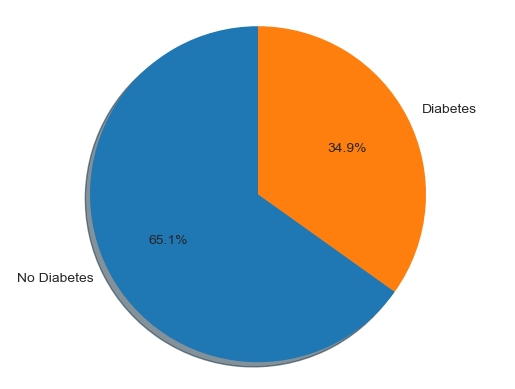

In [3]:
labels='No Diabetes','Diabetes'
size0, size1 = df["Outcome"].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


From the plot, we can see that in the dataset 65.1% of women are classified as "Non-Diabetic", while the 34.9% are classified as diabetic. 

# AIF360

AIF360 is a system used in order to detect and mitigate a possible bias inside a dataset. 
It requires firstly the identification of the corresponding protected attribute(sex,race,age etc..)
The protected attribute should be binary, otherwise we need to binarize the variable.

In this case study the protected attribute(age) is numeric. So we need to binarize the variable: if the age is greater then 25 we identify a women as "Adult", otherwise "Young".

In [4]:
def età(row):
    if(row["Age"]>25):
        return 'Adult'
    else:
        return 'Young'

In [5]:
df["AgeCategory"]=df.apply(lambda row: età(row), axis=1)

In [6]:
df.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,0,6.0,148,72.0,35.0,30.5,33.6,0.627,50.0,1,Adult
1,1,1.0,85,66.0,29.0,30.5,26.6,0.351,31.0,0,Adult
2,2,8.0,183,64.0,23.0,30.5,23.3,0.672,32.0,1,Adult
3,3,1.0,89,66.0,23.0,94.0,28.1,0.167,21.0,0,Young
4,4,0.0,137,40.0,35.0,168.0,43.1,0.374,33.0,1,Adult


## Density

In [7]:
def visualize_att_dist(_data, _att, _category=False):
    plt.figure(figsize=[12,5], dpi=100)
    sns.set(style="darkgrid")  
    sns.set(font_scale = 1.5)
    if _category: # for categorical attribute
        vis_data = _data[_att].value_counts()
        ax = sns.barplot(x=vis_data.index, y=vis_data.values);
        ax.set_xlabel(_att)
        if len(vis_data) >= 5:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    else:
        ax = sns.distplot(_data[_att], kde=False, color='steelblue');
    ax.set_ylabel("Count")
    plt.tight_layout()

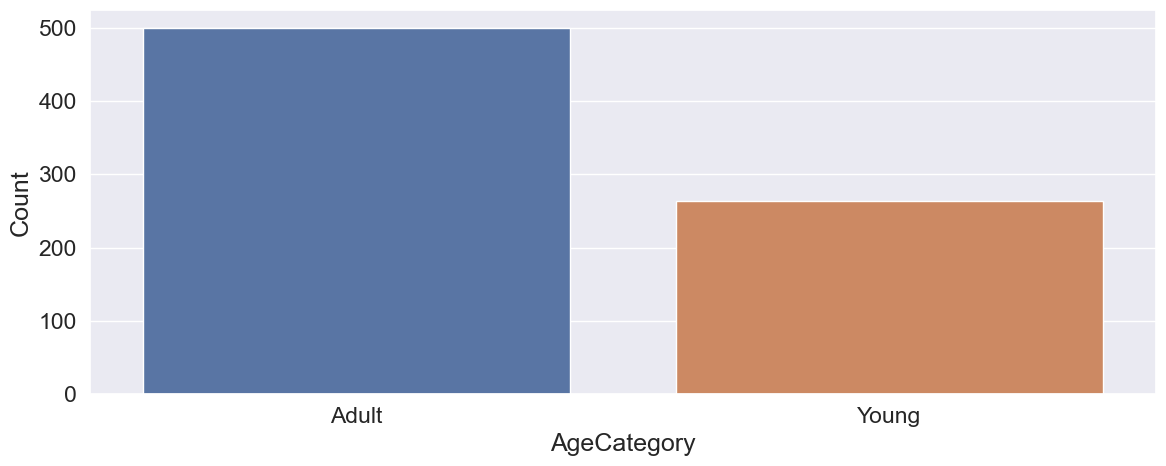

In [8]:
visualize_att_dist(df, "AgeCategory", _category=True)

In [9]:
df=df.replace({"Adult":1})

In [10]:
df=df.replace({"Young":0})

In [11]:
df1=df.copy()

In [12]:
data_orig_age = BinaryLabelDataset(
    favorable_label=1, 
    unfavorable_label=0,
    df=df1, 
    label_names=['Outcome'], 
    protected_attribute_names=['AgeCategory'])

In [13]:
np.random.seed(42)

data_orig_age_train, data_orig_age_test = data_orig_age.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Age :",data_orig_age_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Age :",data_orig_age_test.features.shape)

#### Train Dataset shape

Age : (534, 10)


#### Test Dataset shape

Age : (229, 10)


In [14]:
rf_orig_age = RandomForestClassifier().fit(data_orig_age_train.features, 
                     data_orig_age_train.labels.ravel(), 
                     sample_weight=data_orig_age_train.instance_weights)

In [15]:
X_test_age = data_orig_age_test.features
y_test_age = data_orig_age_test.labels.ravel()

In [16]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

This function plot the metrics of AIF360

In [17]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics for the Sex model

/var/folders/j9/h674cmkj05lfv8z1nlwh_dk40000gn/T/ipykernel_2715/2902889714.py:37: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the AgeCategory attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
AgeCategory,-0.377858,-0.484848,0.368333,0.107378,0.179769


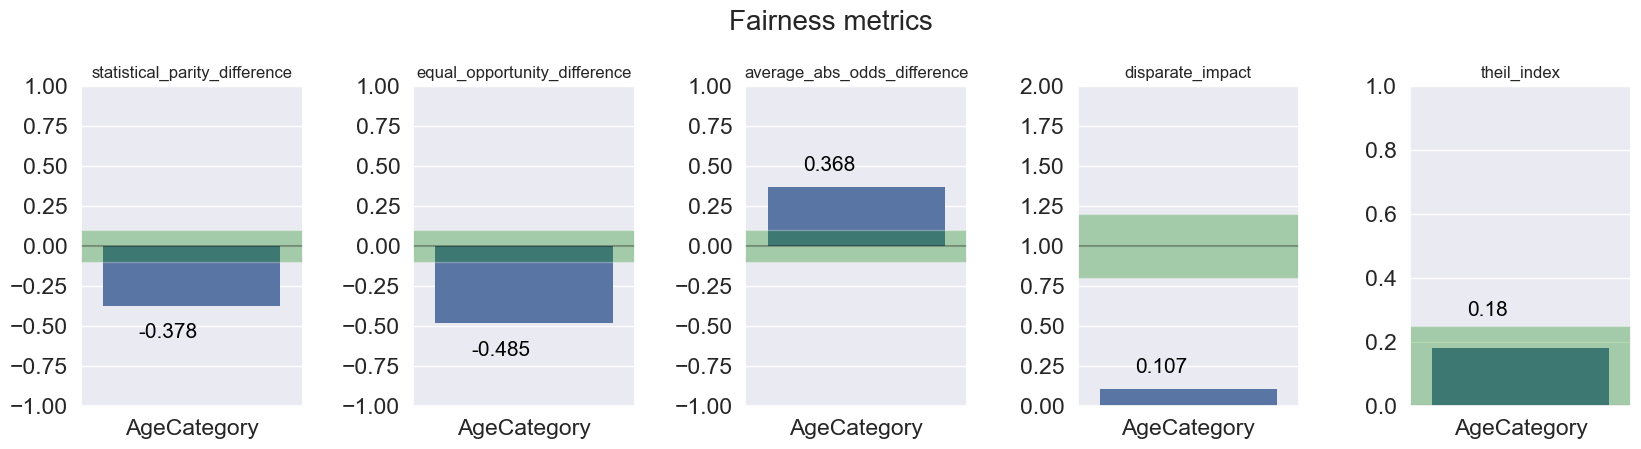

In [18]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_age_test, rf_orig_age)